* Retrieve ticker data from API, parse to CSV
* Explore timeseries and beta for a set of tickers
* Experiment: Does Monday predict the week? NO, it doesn't

In [342]:
import copy, datetime, json, logging, os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# These are my custom libraries
import markets_lib as ml

logging.basicConfig(format = '%(funcName)s %(asctime)-25s %(message)s', level = logging.INFO)

<a id='from_api'></a>

### Retrieve ticker data from API

* Retrieve price date from API. 
* Parse the response into a list of (datestring, price) tuples. 
* Create a dataframe with datestring and price columns.
* Save to CSV

In [343]:
# # Comment this block out when not using - so we don't accidentally spend API calls

# ticker = 'SPY'
# #av_func = 'TIME_SERIES_INTRADAY_EXTENDED'
# av_func = 'TIME_SERIES_INTRADAY'
# #av_func = 'TIME_SERIES_WEEKLY_ADJUSTED'
# #av_func = 'TIME_SERIES_DAILY'
# save = True

# parameters = {'outputsize':'full'} # Weekly/Daily
# parameters = {'outputsize':'full', 'interval':'15min', 'adjusted':'true'} # Intraday
# av_response = ml.alphavantage.call_api(symbol=ticker, function=av_func, parameters=parameters)
# parsed_response, cols = ml.alphavantage.parse_response(av_response, function=av_func)
# if parsed_response:
#     timeseries = ml.timeseries.timeseries_df(parsed_response, cols) 
# print(timeseries)

# if save:
#     filename = '/Users/anupam/Desktop/Server/market_data/{}/{}.csv'.format(av_func, ticker)
#     timeseries.to_csv(filename, float_format='%.3f')
#     print('Saved to {}'.format(filename))

<a id='single_ticker'></a>

## Explore small group of related tickers

In [340]:
# tickers, label = ['TM', 'F', 'GM', 'STLA', 'HMC', 'TTM', 'SPY'], 'Car makers - traditional'
# tickers, label = ['TSLA', 'NIO', 'LI', 'RIVN', 'LCID', 'ARVL'], 'Car makers - electric'
# tickers, label = ['MSFT','ADBE','CRM','ORCL','INTU','SAP','NOW','TEAM','WDAY','PANW'], 'Large cap software'
tickers, label = ['NVDA', 'AMD', 'QCOM', 'INTC', 'NXPI'], 'Semiconductors'
# tickers, label = ['SPY','TQQQ', 'SOXL', 'LABU', 'SQQQ', 'SOXS', 'LABD', 'CURE', 'DFEN'], 'Leveraged ETFs'

2022-09-25 13:54:34,203   adjust_splits():   NVDA: 4:1 split detected on 2021-07-20 00:00:00
2022-09-25 13:54:34,285   adjust_splits():   NVDA: 2:1 split detected on 2006-04-07 00:00:00
2022-09-25 13:54:34,295   adjust_splits():   NVDA: 2:1 split detected on 2004-08-06 00:00:00
2022-09-25 13:54:34,313   adjust_splits():   NVDA: 2:1 split detected on 2001-09-17 00:00:00
2022-09-25 13:54:34,320   adjust_splits():   NVDA: 2:1 split detected on 2000-06-27 00:00:00
/Users/anupam/Desktop/AB/DH/projects/markets/src/markets_lib/timeseries.py:170: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  timeseries = timeseries[self.timeseries['Date']<=pd.Timestamp(end_date)]
2022-09-25 13:54:34,380   adjust_splits():    AMD: 1:2 reverse split detected on 2016-04-22 00:00:00
2022-09-25 13:54:34,459   adjust_splits():    AMD: 2:1 split detected on 2000-08-22 00:00:00
2022-09-25 13:54:34,572   adjust_splits():   QCOM: 2:1 split detected on 2004-08-16 00:00:00
2022-09-25 13:54:

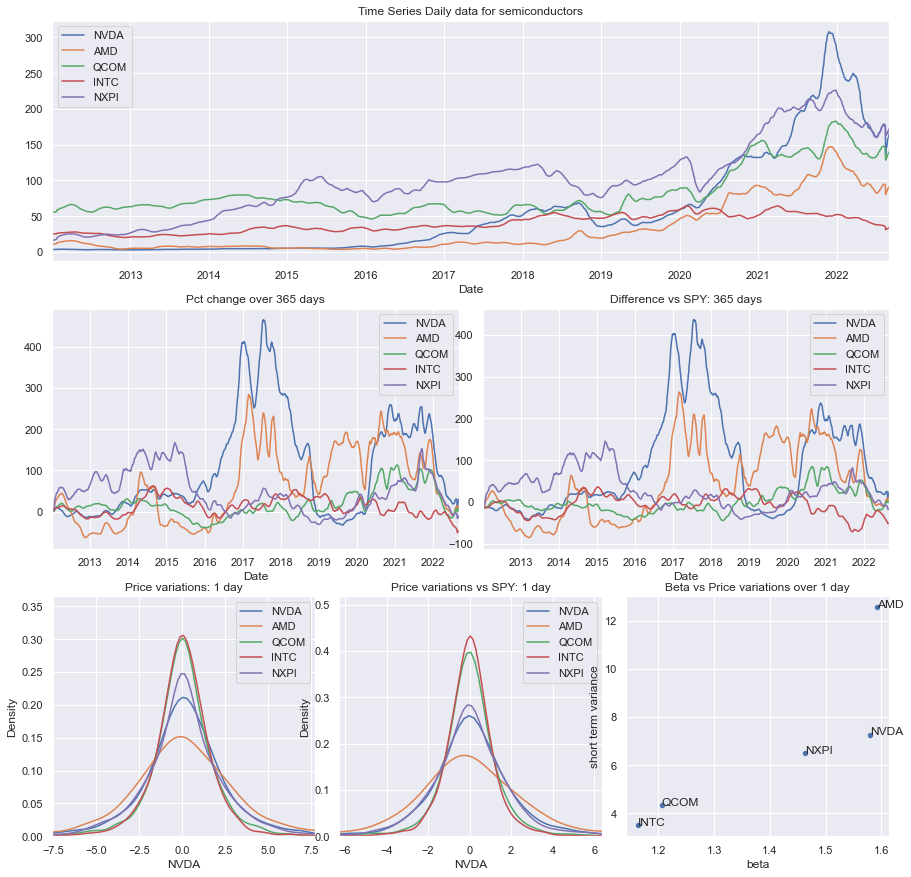

In [341]:
av_func = 'TIME_SERIES_DAILY'
ticker_market = 'SPY'  
start_date = '2012-01-01'
end_date = None
smoothing = 30
window_size_long = 365
window_size_short = 1

# Set up the plot
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15,15))
grid = plt.GridSpec(3,6)
ax_1 = fig.add_subplot(grid[0, :])
ax_2 = fig.add_subplot(grid[1, 0:3])
ax_3 = fig.add_subplot(grid[1, 3:])
ax_4 = fig.add_subplot(grid[2, 0:2])
ax_5 = fig.add_subplot(grid[2, 2:4])
ax_6 = fig.add_subplot(grid[2, 4:6])

# Create list of ticker objects
tss = [ml.timeseries.Ticker(t).\
       daterange_slice(start_date=start_date, end_date=end_date) \
       for t in tickers]

# Plot ticker timeseries
# Merge into single dataframe
mtss_df = ml.timeseries.merge_dfs(tss, how='outer')
p = sns.lineplot(x='Date', y=ml.stats.rolling_avg(mtss_df[tickers[0]], smoothing), data=mtss_df, ax=ax_1)
p.set_title('{} data for {}'.format(av_func.replace('_', ' ').title(), label.lower()))
p.set_xlim((mtss_df['Date'][0], mtss_df['Date'][len(mtss_df['Date'])-1]))
if len(tickers)>1:
    for i in range(1, len(tickers)):
        sns.lineplot(x="Date", y=ml.stats.rolling_avg(mtss_df[tickers[i]], smoothing), data=mtss_df, ax=p)
ax_1.legend(labels=tickers)

# Plot ticker % change over window_size_long
tss_pc = copy.deepcopy(tss)
# Compute pct_nnnn col for each ticker; drop original price col; 
# rename pct_nnnn tp price; merge tickers into single dataframe
tss_pc = [t.pct_change(window_size=window_size_long).drop_columns(drop='Close') for t in tss_pc]
mtss_df = ml.timeseries.merge_dfs(tss_pc, how='outer')
p = sns.lineplot(x='Date', y=ml.stats.rolling_avg(mtss_df[tickers[0]], smoothing), data=mtss_df, ax=ax_2)
p.set_title('Pct change over {} days'.format(window_size_long))
p.set_xlim((mtss_df['Date'][0], mtss_df['Date'][len(mtss_df['Date'])-1]))
if len(tickers)>1:
    for i in range(1, len(tickers)):
        sns.lineplot(x="Date", y=ml.stats.rolling_avg(mtss_df[tickers[i]], smoothing), data=mtss_df, ax=p)
ax_2.legend(labels=tickers)

# Plot ticker pct % over window size as diff from market
# WHY DOES THIS MODIFY TSS - not sure
tss_pc = copy.deepcopy(tss)
# Make sure market ticker is not in the main list
tss_pc = [t for i, t in enumerate(tss_pc) if t.ticker != ticker_market] 
tickers = [t for t in tickers if t != ticker_market]
tm = ml.timeseries.Ticker(ticker_market)
tm.pct_change(window_size=window_size_long)
# Compute pct_nnnn col for each ticker; subtract tm; merge tickers into single dataframe
tss_pc = [t.pct_change(window_size=window_size_long) for t in tss_pc]
tss_pc = [t.map_operation(tm, column='Close_pct_{:04}'.format(window_size_long)) for t in tss_pc]
mtss_df = ml.timeseries.merge_dfs(tss_pc, how='outer')
p = sns.lineplot(x='Date', y=ml.stats.rolling_avg(mtss_df[tickers[0]], smoothing), data=mtss_df, ax=ax_3)
p.set_title('Difference vs {}: {} days'.format(tm.ticker, window_size_long))
p.set_xlim((mtss_df['Date'][0], mtss_df['Date'][len(mtss_df['Date'])-1]))
if len(tickers)>1:
    for i in range(1, len(tickers)):
        sns.lineplot(x="Date", y=ml.stats.rolling_avg(mtss_df[tickers[i]], smoothing), data=mtss_df, ax=p)
ax_3.legend(labels=tickers)

# Plot distributions of short-term variations
tss_pc = copy.deepcopy(tss)
# Compute pct_nnnn col for each ticker; subtract tm; merge tickers into single dataframe
tss_pc = [t.pct_change(window_size=window_size_short) for t in tss_pc]
mtss_df = ml.timeseries.merge_dfs(tss_pc, how='outer')
p = sns.histplot(mtss_df[tickers[0]], ax=ax_4, fill=False, kde=True, stat="density", linewidth=0)
means, stds = zip(*[(mtss_df[c].mean(), mtss_df[c].std()) for c in mtss_df.columns[1:]])
mean = np.mean(means)
std = np.mean(stds)
p.set_title('Price variations: {} day'.format(window_size_short))
p.set_xlim((mean-3*std,mean+3*std))
if len(tickers)>1:
    for i in range(1, len(tickers)):
        sns.histplot(mtss_df[tickers[i]], ax=p, fill=False, kde=True, stat="density", linewidth=0)
ax_4.legend(labels=tickers)

# Plot distributions of short-term variations as difference from market
tss_pc = copy.deepcopy(tss)
# Make sure market ticker is not in the main list
tss_pc = [t for i, t in enumerate(tss_pc) if t.ticker != ticker_market] 
tickers = [t for t in tickers if t != ticker_market]
# Compute pct_nnnn col for each ticker; subtract tm; merge tickers into single dataframe
tss_pc = [t.pct_change(window_size=window_size_short) for t in tss_pc]
tss_pc = [t.map_operation(tm) for t in tss_pc]
mtss_df = ml.timeseries.merge_dfs(tss_pc, how='outer')
p = sns.histplot(mtss_df[tickers[0]], ax=ax_5, fill=False, kde=True, stat="density", linewidth=0)
means, stds = zip(*[(mtss_df[c].mean(), mtss_df[c].std()) for c in mtss_df.columns[1:]])
mean = np.mean(means)
std = np.mean(stds)
p.set_title('Price variations vs {}: {} day'.format(tm.ticker, window_size_short))
p.set_xlim((mean-3*std,mean+3*std))
if len(tickers)>1:
    for i in range(1, len(tickers)):
        sns.histplot(mtss_df[tickers[i]], ax=p, kde=True, fill=False, stat="density", linewidth=0)
ax_5.legend(labels=tickers)

# Plot beta against short term variance
tss_pc = copy.deepcopy(tss)
# Make sure market ticker is not in the main list
tss_pc = [t for i, t in enumerate(tss_pc) if t.ticker != ticker_market] 
tickers = [t for t in tickers if t != ticker_market]
# Compute pct_nnnn col for each ticker; subtract tm; merge tickers into single dataframe
beta = [t.get_beta(tm, window_size=window_size_short) for t in tss_pc]
var = [t.timeseries['Close_pct_{:04}'.format(window_size_short)].var() for t in tss_pc]
mtss_df = pd.DataFrame({'beta': beta, 'short term variance': var}, index=tickers)
p = sns.scatterplot(data=mtss_df, x='beta', y='short term variance', ax=ax_6)
p.set_title('Beta vs Price variations over {} day'.format(window_size_short))
for t in mtss_df.index:
    p.text(mtss_df.loc[t]['beta'], mtss_df.loc[t]['short term variance'], t)